# Gender Classification and Eyes Location Detection: A Two Task Problem

In this example, we are going to implement a multi-task problem. We try to identify the gender of the people, as well as locating their eyes in the image. Hence, we have two different tasks: classification (to identify the gender) and regression (to find the location of the eyes). We are going to use a single network (A CNN) to perform both tasks, however, we will need to apply different loss functions, each proper to a specific task. 

In [1]:
%pip install poutyne    # to install the Poutyne library

     |████████████████████████████████| 143kB 23.7MB/s 


Let’s import all the needed packages.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
import zipfile
import cv2
from natsort import natsorted
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid


## Training Constants

In [3]:
num_epochs = 15
learning_rate = 0.01
batch_size = 32
image_size = 224
valid_split_percent = 0.1
momentum = 0.5
set_seeds(42)
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing 
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device) 

The running processor is... cuda


## CelebA Dataset

We are going to use CelebA dataset for this experiment. The CelebA 
dataset  is a large-scale face attributes dataset which can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.

## Fetching data 


The section below consists of a few lines of codes that help us download celebA dataset from a public web source and unzip them.

In [ ]:
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'

# URL for the CelebA dataset (aligned images, attributes, landmasrks)
url = 'https://graal.ift.ulaval.ca/public/celeba/img_align_celeba.zip'
attr_url = 'https://graal.ift.ulaval.ca/public/celeba/list_attr_celeba.txt'
land_mark_url = 'https://graal.ift.ulaval.ca/public/celeba/list_landmarks_align_celeba.txt'

# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'
land_mark_path = f'{data_root}/list_landmarks_align_celeba.txt'
attr_path = f'{data_root}/list_attr_celeba.txt'

# Create required directories 
os.makedirs(data_root, exist_ok=True)
os.makedirs(dataset_folder, exist_ok=True)

# Download the dataset from the source
gdown.download(url, download_path, quiet=False)
gdown.download(land_mark_url, land_mark_path, quiet=False)
gdown.download(attr_url, attr_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom dataset class

As we are going to implement a multi-task problem by a single CNN, we should provide the CNN with the ground truth in a proper way. Here, we have two different tasks: classification and regression. In the classification task, the goal is to identify the gender. The labels of the gender for each image are saved in the `list_attr_celeba.txt` file, in which 1 stands for male and -1 for female. Since we consider the loss of both tasks simultaneously, we scale all target values to the range of [0,1]. Hence, the gender labels will be changed as well, 1 for male and 0 for female. For the localization part, the coordinates of the eyes (Left and Right) are provided in the `list_landmarks_align_celeba.txt` file. In addition to scaling the number to the range of [0,1], we also need to rescale the coordinates to the image's new size (224,224).

In [ ]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    img_folder = data_root + '/img_align_celeba/img_align_celeba'
    image_names = os.listdir(img_folder)
    self.root_dir = img_folder
    self.data_root = data_root
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    img = cv2.imread(img_path)
    w, h, _ = img.shape
    img = cv2.resize(img, (image_size, image_size))

    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    img.requires_grad=True
    land_mark = open(f'{self.data_root}/list_landmarks_align_celeba.txt','r').readlines()[idx+2]
    land_mark_contents = land_mark.split(' ')
    land_mark_contents = [x for x in land_mark_contents if x]
    x_L, y_L ,x_R, y_R = int(land_mark_contents[1]), int(land_mark_contents[2]), int(land_mark_contents[3]), int(land_mark_contents[4])
    w_scale = image_size/w
    h_scale = image_size/h
    x_L, x_R = (x_L*h_scale/h), (x_R*h_scale/h)  #rescaling for the size of (224,224) and finaly to the range of [0,1]
    y_L, y_R = (y_L*w_scale/w), (y_R*w_scale/w)
    attr = open(f'{self.data_root}/list_attr_celeba.txt','r').readlines()[idx+2]
    attr_contents = attr.split(' ')
    attr_contents = [x for x in attr_contents if x]
    gender = attr_contents[21]
    gender = int((int(gender)+1)/2)
    return img, (torch.tensor(gender), torch.tensor([x_L, y_L, x_R, y_R], requires_grad=True),[w, h])

transform=tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(imagenet_mean, imagenet_std)
])

celeba_dataset = CelebADataset(data_root, transform)
celeba_dataloader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)
full_dataset_length = len(celeba_dataset)
indices = list(np.arange(full_dataset_length))
np.random.shuffle(indices)
train_indices = indices[math.floor(full_dataset_length * valid_split_percent):]
valid_indices = indices[:math.floor(full_dataset_length * valid_split_percent)]
train_dataset = Subset(celeba_dataset, train_indices)
valid_dataset = Subset(celeba_dataset, valid_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Here we can see how each dataset sample looks like:

In [ ]:
print (train_dataset[0])

(tensor([[[-0.4226, -0.4226, -0.4226,  ...,  0.5536,  0.5536,  0.5536],
         [-0.4226, -0.4226, -0.4226,  ...,  0.5536,  0.5536,  0.5536],
         [-0.4226, -0.4226, -0.4226,  ...,  0.5536,  0.5536,  0.5536],
         ...,
         [-1.7583, -1.7240, -1.6898,  ..., -0.8678, -0.9020, -0.9192],
         [-1.7754, -1.7754, -1.7583,  ..., -0.9192, -0.9192, -0.9363],
         [-1.8439, -1.8268, -1.8097,  ..., -0.9192, -0.9192, -0.9363]],

        [[-0.8102, -0.8102, -0.8102,  ...,  0.4153,  0.4153,  0.4153],
         [-0.8102, -0.8102, -0.8102,  ...,  0.4153,  0.4153,  0.4153],
         [-0.8102, -0.8102, -0.8102,  ...,  0.4153,  0.4153,  0.4153],
         ...,
         [-1.7906, -1.7206, -1.6681,  ..., -0.3200, -0.3025, -0.3025],
         [-1.7381, -1.7206, -1.6856,  ..., -0.3200, -0.2850, -0.2850],
         [-1.7381, -1.7206, -1.6856,  ..., -0.3200, -0.2850, -0.2850]],

        [[-1.0550, -1.0550, -1.0550,  ...,  0.3568,  0.3568,  0.3568],
         [-1.0550, -1.0550, -1.0550,  ...,  

In [ ]:
# this cell will be removed (just a smaller sized dataset to find hyper parameters)
z = Subset(celeba_dataset, np.arange(1,100))
z1 = Subset(celeba_dataset, np.arange(1,300))
train_dataloader = DataLoader(z1, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(z, batch_size=batch_size, shuffle=True)

Here, we can see an example from the training dataset. It shows an image of a person, printing the gender and also showing the location of the eyes.

Gender is:  female


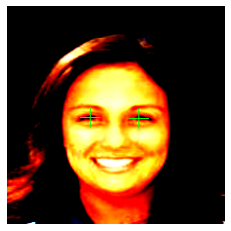

In [ ]:
sample_number = 16
image = train_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
Gender = 'male' if int(train_dataset[sample_number][1][0])==1 else 'female'
print('Gender is: ', Gender)
w, h = train_dataset[sample_number][1][2]
(x1, y1) = train_dataset[sample_number][1][1][0:2]
(x2, y2) = train_dataset[sample_number][1][1][2:4]
x1, x2 = int(x1*h), int(x2*h)
y1, y2 = int(y1*w), int(y2*w)
image_rgb	=	cv2.drawMarker(image_rgb, (x1,y1), (0,255,0))
image_rgb	=	cv2.drawMarker(image_rgb, (x2,y2), (0,255,0))
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Network

Below, we define a new class, named 'ClassifierLocalizer, which accepts a pre-trained CNN and changes its last fully connected layer to be proper for the two task problem. The new fully connected layer contains 6 neurons, 2 for the classification task (male or female) and 4 for the localization task (x and y for the left and right eyes). Moreover, to put the location results on the same scale as the class scores, we apply the sigmoid function to the neurons assigned for the localization task.

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = models.__dict__[model_name](True)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 6) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # coordinates
        return [scores, torch.sigmoid(coords)]   # sigmoid output is in the range of [0, 1]

Regarding the complexity of the problem, the number of the samples in the training dataset, and the similarity of the training dataset to the ImageNet dataset, we may decide to freeze some of the layers. In our current example, based on the mentioned factors, we freeze just the last fully connected layer.

In [ ]:
network = ClassifierLocalizer(model_name='resnet18')

def freeze_weights(network):
    for name, param in network.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(network)
print(network)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ClassifierLocalizer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
network = ClassifierLocalizer(model_name='resnet18')  # network without freezing any layer.

By using the `callbacks` feature in the Poutyne, we will be able to load the network with the best weights. This fetures saves the latest weights of the network during training, as well as saving the best weights during the several epochs of training. 

In [ ]:
save_path = './callbacks'
os.makedirs(save_path, exist_ok=True)
callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}.ckpt'), monitor='val_loss', mode='min',
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

## Loss function

As we discussed before, we have two different tasks in this example. These tasks need different loss functions; Cross-Entropy loss for the classification and Mean Square Error loss for the regression. Below, we define a new loss function class that sums both losses to considers them simultaneously. However, as the regression is relatively a harder task, we apply a higher weight to MSEloss.

In [ ]:
class ClassificationRegressionLoss(nn.Module):
    def __init__(self):
        super(ClassificationRegressionLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss() # size_average=False
        self.mse_loss = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        loss_cls = self.ce_loss(y_pred[0], y_true[0]) # Cross Entropy Error (for classification)
        loss_reg = self.mse_loss(y_pred[1], y_true[ 1]) # Mean Squared Error (for landmarks)
        total_loss = loss_reg + loss_cls
        return total_loss

## Training

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.0001, weight_decay=0)
loss_function = ClassificationRegressionLoss()
#Step_Learning_Rate = StepLR(step_size=2 , gamma=0.1, last_epoch=-1, verbose=False)
exp = Experiment('./two_task_example', network, optimizer=optimizer, loss_function=loss_function, device="all")
exp.train(train_dataloader, valid_dataloader, callbacks=callbacks, epochs=num_epochs)

Epoch:  1/15 Train steps: 10 Val steps: 4 46.30s loss: 0.445424 val_loss: 0.065863
Epoch 1: val_loss improved from inf to 0.06586, saving file to ./two_task_example/checkpoint_epoch_1.ckpt
Epoch 1: val_loss improved from inf to 0.06586, saving file to ./callbacks/best_epoch_1.ckpt
Epoch:  2/15 Train steps: 10 Val steps: 4 46.32s loss: 0.055802 val_loss: 0.018385
Epoch 2: val_loss improved from 0.06586 to 0.01838, saving file to ./two_task_example/checkpoint_epoch_2.ckpt
Epoch 2: val_loss improved from 0.06586 to 0.01838, saving file to ./callbacks/best_epoch_2.ckpt
Epoch:  3/15 Train steps: 10 Val steps: 4 46.32s loss: 0.018117 val_loss: 0.006982
Epoch 3: val_loss improved from 0.01838 to 0.00698, saving file to ./two_task_example/checkpoint_epoch_3.ckpt
Epoch 3: val_loss improved from 0.01838 to 0.00698, saving file to ./callbacks/best_epoch_3.ckpt
Epoch:  4/15 Train steps: 10 Val steps: 4 45.96s loss: 0.008695 val_loss: 0.005553
Epoch 4: val_loss improved from 0.00698 to 0.00555, sav

[{'epoch': 1,
  'loss': 0.44542360545002097,
  'time': 46.296777523999936,
  'val_loss': 0.065862835657717},
 {'epoch': 2,
  'loss': 0.05580225504660686,
  'time': 46.32107198299991,
  'val_loss': 0.01838479984100118},
 {'epoch': 3,
  'loss': 0.018116830533563492,
  'time': 46.32259177299966,
  'val_loss': 0.006982036381771769},
 {'epoch': 4,
  'loss': 0.008694756751176107,
  'time': 45.958429328999955,
  'val_loss': 0.005552749883270625},
 {'epoch': 5,
  'loss': 0.006221386373516508,
  'time': 46.25863487700008,
  'val_loss': 0.003450976183750864},
 {'epoch': 6,
  'loss': 0.0050482390616649764,
  'time': 46.626975122000204,
  'val_loss': 0.002240448512814262},
 {'epoch': 7,
  'loss': 0.004153520859354316,
  'time': 46.86461072799966,
  'val_loss': 0.001678546481398922},
 {'epoch': 8,
  'loss': 0.002158965720767062,
  'time': 46.198860033000074,
  'val_loss': 0.0012906256503416131},
 {'epoch': 9,
  'loss': 0.001411929754633768,
  'time': 46.49014936100002,
  'val_loss': 0.0010059040246

## Evaluation

As you have also noticed from the training logs, we have achieved the best performance (considering the validation loss) at the 15th epoch. The weights of the network for the corresponding epoch have been automatically saved and we use these parameters to evaluate our algorithm visually. Hence,  we take advantage of evaluate function of Poutyne, and apply it to the validation dataset. It provides us the predictions as well as the ground-truth for comparison, in case of need.

In [ ]:
model = Model(network, optimizer, loss_function, device=device)
model.load_weights('./two_task_example/checkpoint_epoch_15.ckpt')
loss, predictions, Ground_Truth = model.evaluate_generator(valid_dataloader, callbacks=callbacks, return_pred=True, return_ground_truth=True)

Test steps: 4 11.08s test_loss: 0.000417                              


The `callbacks` feature also records the training logs. we can use this information to monitor and analyze the training process.

In [ ]:
logs = pd.read_csv('./callbacks/log.tsv', sep='\t')
print(logs)

    epoch       time      lr      loss  val_loss
0       1  46.296778  0.0001  0.445424  0.065863
1       2  46.321072  0.0001  0.055802  0.018385
2       3  46.322592  0.0001  0.018117  0.006982
3       4  45.958429  0.0001  0.008695  0.005553
4       5  46.258635  0.0001  0.006221  0.003451
5       6  46.626975  0.0001  0.005048  0.002240
6       7  46.864611  0.0001  0.004154  0.001679
7       8  46.198860  0.0001  0.002159  0.001291
8       9  46.490149  0.0001  0.001412  0.001006
9      10  46.412683  0.0001  0.001848  0.000800
10     11  45.674126  0.0001  0.001584  0.000678
11     12  45.724542  0.0001  0.000935  0.000622
12     13  45.112543  0.0001  0.001359  0.000542
13     14  45.400197  0.0001  0.001054  0.000468
14     15  45.581703  0.0001  0.001436  0.000417


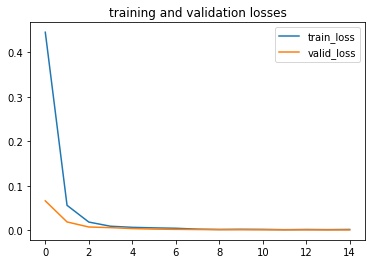

In [ ]:
train_loss = logs.loss
valid_loss = logs.val_loss
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss','valid_loss'])
plt.title('training and validation losses')
plt.show()

We can also evaluate the performance of the trained network (a network with the best weights) on any dataset, as below:

In [ ]:
exp.test(valid_dataloader)

Found best checkpoint at epoch: 15
lr: 0.0001, loss: 0.00143557, val_loss: 0.000416681
Loading checkpoint ./two_task_example/checkpoint_epoch_15.ckpt
Running test
Test steps: 4 11.32s test_loss: 0.000417                              


{'test_loss': 0.00041668165141170975, 'time': 11.319942566999998}

Now let's evaluate the performance of the network visually.

Gender is:  male


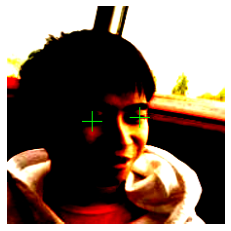

In [ ]:
sample_number = 10
image = valid_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
#Gender = 'male' if np.where(predictions[0][sample_number]==max(predictions[0][sample_number]))[0]==0 else 'female'
Gender = 'male' if np.argmax(predictions[0][sample_number])==0 else 'female'
print('Gender is: ', Gender)
w, h = valid_dataset[sample_number][1][2]
(x1, y1) = predictions[1][sample_number][0:2]
(x2, y2) = predictions[1][sample_number][2:4]
x1, x2 = int(x1*h), int(x2*h)
y1, y2 = int(y1*w), int(y2*w)
image_rgb	=	cv2.drawMarker(image_rgb, (x1,y1), (0,255,0))
image_rgb	=	cv2.drawMarker(image_rgb, (x2,y2), (0,255,0))
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()